# Preliminary Data Analysis and Technical indicators of NVDA Stock

#### Imports of required libraries

In [5]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.0 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pandas_datareader as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import statsmodels as smt
import warnings
warnings.filterwarnings('ignore')

### Data fetching from yahoo finance

In [7]:
ticker = 'NVDA'
start = datetime(2017 , 1 ,1)
end = datetime(2021, 12 , 31)
NVDA = yf.download(ticker, start, end, adjusted=True)

[*********************100%***********************]  1 of 1 completed


### Plotting opening and closing prices

0.9995637536070892

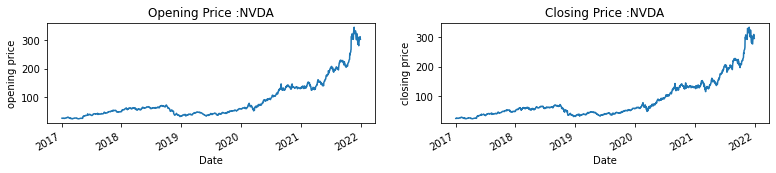

In [10]:
#open price
fig = plt.figure(figsize=(20, 7))
openPrice_plt = plt.subplot2grid((3, 3), (1,0))
high = NVDA['High']
high.grid = True
openPrice_plt.set_title('Opening Price :' + 'NVDA')
openPrice_plt.set_xlabel('years')
openPrice_plt.set_ylabel('opening price')
high.plot(ax=openPrice_plt)
#close price
closePrice_plt = plt.subplot2grid((3, 3), (1,1))
close = NVDA['Close']
close.grid = True
closePrice_plt.set_title('Closing Price :' + 'NVDA')
closePrice_plt.set_xlabel('years')
closePrice_plt.set_ylabel('closing price')

close.plot(ax=closePrice_plt)

returns = np.diff(close)
#correlation
high.corr(close)

## Moving Average

In [12]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')

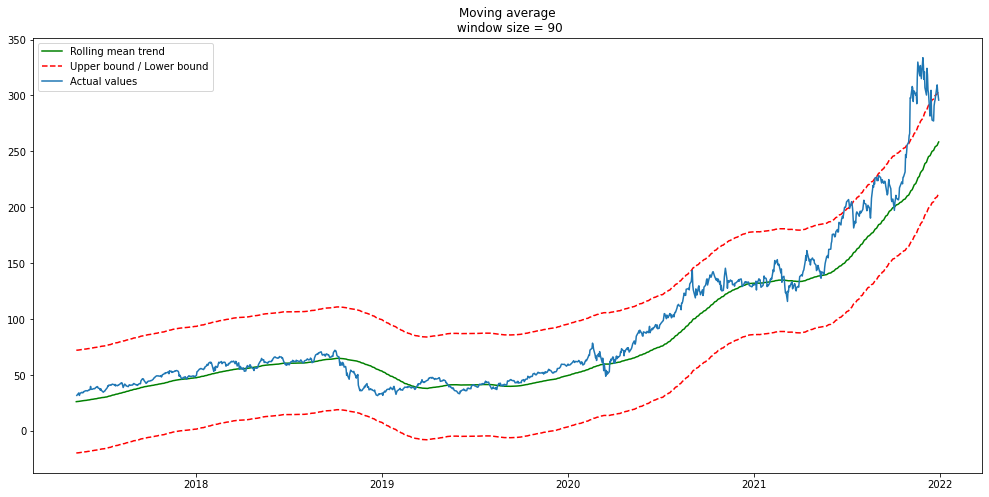

In [14]:
plot_moving_average(NVDA['Close'], 90, plot_intervals=True)

## Time series plot

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

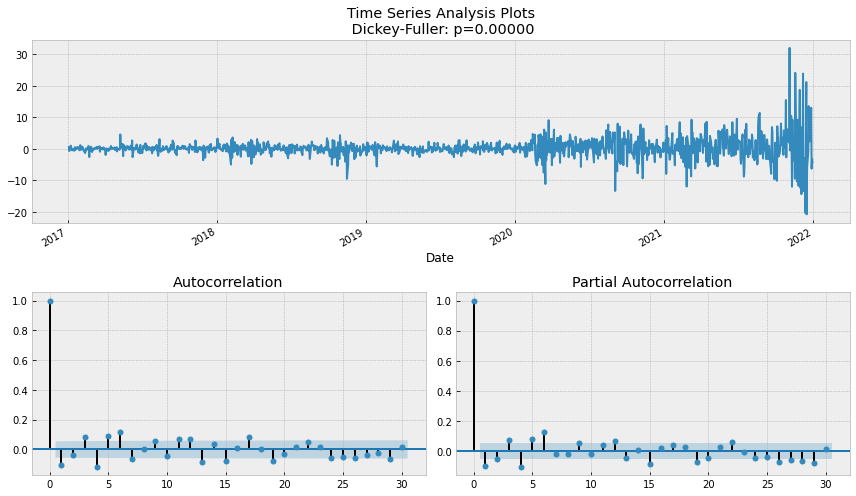

In [16]:
data_diff = NVDA['Close'] - NVDA['Close'].shift(1)
tsplot(data_diff[1:], lags=30) 

# Kernel Density

count    1258.000000
mean       86.302645
std        65.503116
min        23.587660
25%        41.944397
50%        59.748220
75%       127.463551
max       333.662292
Name: Adj Close, dtype: float64

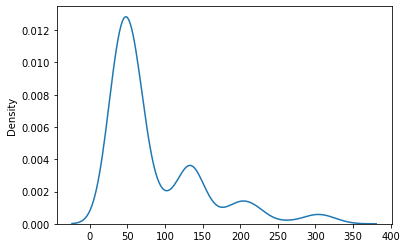

In [17]:
kde = NVDA['Adj Close'].values
sns.kdeplot(data=kde)
NVDA['Adj Close'].describe()

# Bollinger Band

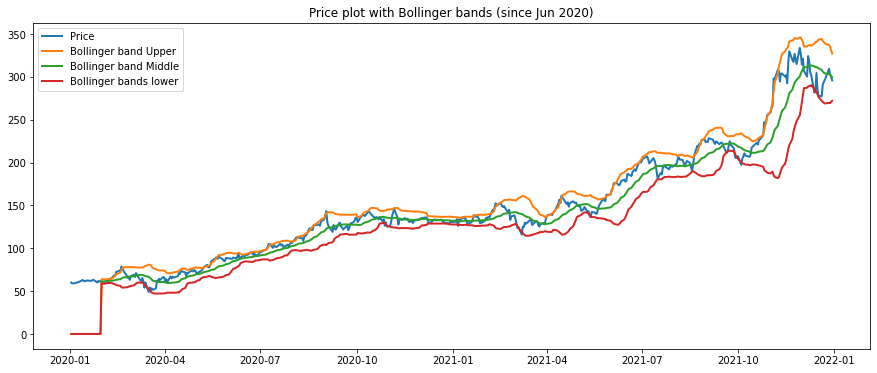

In [18]:
newDf_2 = NVDA['2020-01-01':].copy()
window = 21; no_of_std = 2
rollingMean = newDf_2.Close.rolling(window).mean(); rollingStd = newDf_2.Close.rolling(window).std()
newDf_2['bbUp'] = (rollingMean + (rollingStd* no_of_std)).fillna(0.0)
newDf_2['bbMiddle'] =  newDf_2['Close'].rolling(window).mean()
newDf_2['bbLow'] = (rollingMean - (rollingStd* no_of_std)).fillna(0.0)
fig = plt.figure(figsize = (15,6))
plt.plot(newDf_2['Close'], lw=2.); plt.plot(newDf_2['bbUp'], lw=2.)
plt.plot(newDf_2['bbMiddle'], lw=2. ); plt.plot(newDf_2['bbLow'], lw=2.)
plt.legend(["Price","Bollinger band Upper", "Bollinger band Middle","Bollinger bands lower"])
plt.title("Price plot with Bollinger bands (since Jun 2020)")
plt.show()

# Moving Average crossover

In [19]:
shortWindow = 5
longWindow = 15
trade = NVDA[['Close']]
trade['tradeSignal'] = 0.0
trade['shortMavg'] = NVDA['Close'].rolling(window=shortWindow).mean()
trade['longMavg'] = NVDA['Close'].rolling(window=longWindow).mean()
trade['tradeSignal'][shortWindow:] = np.where(trade['shortMavg'][shortWindow:] < trade['longMavg'][shortWindow:], 1.0, 0.0)
trade['act'] = trade['tradeSignal'].diff()
print(trade.tail());
print('-'*32)
print(trade['act'].value_counts())


                 Close  tradeSignal   shortMavg    longMavg  act
Date                                                            
2021-12-23  296.399994          1.0  287.270001  296.433331  0.0
2021-12-27  309.450012          1.0  293.558002  296.601333  0.0
2021-12-28  303.220001          0.0  298.764001  296.791333 -1.0
2021-12-29  300.010010          0.0  300.616003  295.174001  0.0
2021-12-30  295.859985          0.0  300.988000  293.680666  0.0
--------------------------------
 0.0    1169
 1.0      44
-1.0      44
Name: act, dtype: int64


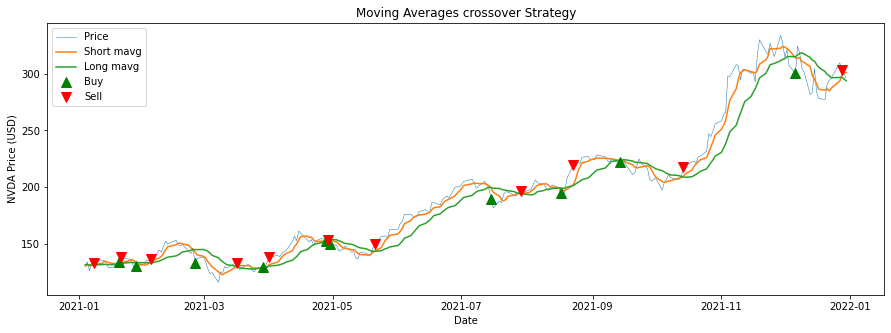

In [20]:
plot3 = trade['2021-01-01':].copy()
buys = plot3.loc[plot3['act'] == 1]
sells = plot3.loc[plot3['act'] == -1]
# Plot
fig = plt.figure(figsize=(15, 5))
plt.plot(plot3.index, plot3['Close'], lw=.5, label='Close price')
plt.plot(plot3[['shortMavg', 'longMavg']])
plt.plot(buys.index, plot3.loc[buys.index]['Close'], '^', markersize=10, color='g', lw=2., label='Buy')
plt.plot(sells.index, plot3.loc[sells.index]['Close'], 'v', markersize=10, color='red', lw=2., label='Sell')
plt.ylabel('NVDA Price (USD)')
plt.xlabel('Date')
plt.legend(["Price","Short mavg","Long mavg","Buy","Sell"])
plt.title("Moving Averages crossover Strategy")
plt.show()

# GARCH model

In [21]:
def GARCH(param, *args):
 "Initialize Params:"
 mu = param[0]
 omega = param[1]
 alpha = param[2]
 beta = param[3]
 T = Y.shape[0]
 GARCH_Dens = np.zeros(T) 
 sigma2 = np.zeros(T)   
 F = np.zeros(T)   
 v = np.zeros(T)   
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    v[t] = sigma2[t]
    GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+\
                    (1/2)*(F[t]/v[t])     
    Likelihood = np.sum(GARCH_Dens[1:-1])  
    return Likelihood

In [22]:
def GARCH_PROD(params, Y0, T):
 mu = params[0]
 omega = params[1]
 alpha = params[2]
 beta = params[3]
 Y = np.zeros(T)  
 sigma2 = np.zeros(T)
 Y[0] = Y0
 sigma2[0] = 0.003
 for t in range(1,T):
    sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]); 
    Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)    
 return Y   

In [24]:
Y = np.diff(np.log(NVDA['Adj Close'].values))
T = Y.shape[0]

         Current function value: -6.341586
         Iterations: 0
         Function evaluations: 91
         Gradient evaluations: 14


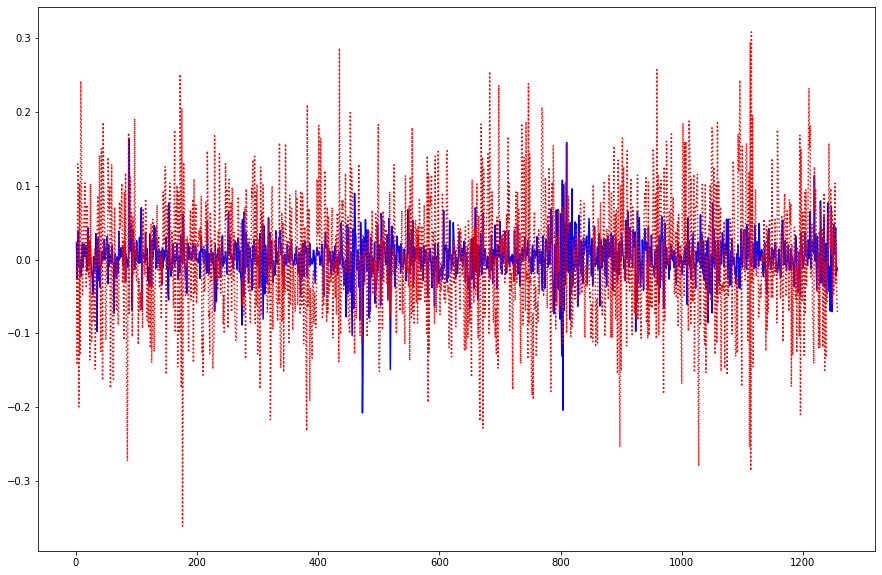

In [25]:
param0 = np.array([0, 0.003, 0.3, 0.3])
param_star = minimize(GARCH, param0, method='BFGS', options={'xtol': 1e-8, 'disp': True})
Y_GARCH = GARCH_PROD(param_star.x, Y[0], T)
fig = plt.figure(figsize=(15, 10))
timevec = np.linspace(1, T, T)
plt.plot(timevec, Y, 'b')
plt.plot(timevec, Y_GARCH,'r:')
plt.show()